# Environment

In [4]:
# version
import jcopdl, luwiji
jcopdl.__version__, luwiji.__version__

('1.1.1', '1.1.2')

# Import Package

In [6]:
# import common packages
import numpy as np
import matplotlib.pyplot as plt

# import PyTorch's common packages
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

# checking for GPU/CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & DataLoader

In [7]:
# import packages
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
bs = 128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [9]:
# Sanity Check
feature, target = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [10]:
# label
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Architecture and Config

In [11]:
# import package
from jcopdl.layers import conv_block, linear_block

In [12]:
# build architecture
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 10, activation="lsoftmax")
        )
        
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

In [13]:
# set config
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation -> MCOC

In [14]:
# Model
model = CustomCNN().to(device)

# Criterion
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Callback
callback = Callback(model, config, outdir="model")

# Training

In [15]:
# training with loop function
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct/ len(dataset)
    return cost, acc



Epoch     1
Train_cost  = 1.7932 | Test_cost  = 0.7593 | Train_score = 0.4310 | Test_score = 0.5000 |




Epoch     2
Train_cost  = 0.7236 | Test_cost  = 0.6750 | Train_score = 0.5350 | Test_score = 0.5325 |




Epoch     3
Train_cost  = 0.8009 | Test_cost  = 0.7487 | Train_score = 0.5120 | Test_score = 0.5025 |
==> EarlyStop patience =  1 | Best test_score: 0.5325




Epoch     4
Train_cost  = 0.7122 | Test_cost  = 0.6733 | Train_score = 0.5370 | Test_score = 0.5425 |




Epoch     5
Train_cost  = 0.6773 | Test_cost  = 0.6648 | Train_score = 0.5810 | Test_score = 0.6225 |




Epoch     6
Train_cost  = 0.6706 | Test_cost  = 0.6517 | Train_score = 0.6000 | Test_score = 0.6350 |




Epoch     7
Train_cost  = 0.6506 | Test_cost  = 0.6230 | Train_score = 0.6400 | Test_score = 0.6875 |




Epoch     8
Train_cost  = 0.6070 | Test_cost  = 0.6058 | Train_score = 0.6850 | Test_score = 0.6750 |
==> EarlyStop patience =  1 | Best test_score: 0.6875




Epoch     9
Train_cost  = 0.6063 | Test_cost  = 0.5802 | Train_score = 0.6760 | Test_score = 0.7225 |




Epoch    10
Train_cost  = 0.5795 | Test_cost  = 0.5474 | Train_score = 0.7160 | Test_score = 0.7475 |




Epoch    11
Train_cost  = 0.5255 | Test_cost  = 0.4915 | Train_score = 0.7510 | Test_score = 0.7850 |




Epoch    12
Train_cost  = 0.4965 | Test_cost  = 0.4606 | Train_score = 0.7490 | Test_score = 0.8000 |




Epoch    13
Train_cost  = 0.4569 | Test_cost  = 0.4292 | Train_score = 0.7810 | Test_score = 0.8150 |




Epoch    14
Train_cost  = 0.4287 | Test_cost  = 0.4056 | Train_score = 0.8030 | Test_score = 0.8000 |
==> EarlyStop patience =  1 | Best test_score: 0.8150




Epoch    15
Train_cost  = 0.4095 | Test_cost  = 0.4001 | Train_score = 0.8290 | Test_score = 0.8225 |




Epoch    16
Train_cost  = 0.4163 | Test_cost  = 0.4415 | Train_score = 0.8170 | Test_score = 0.7900 |
==> EarlyStop patience =  1 | Best test_score: 0.8225




Epoch    17
Train_cost  = 0.4171 | Test_cost  = 0.4121 | Train_score = 0.8070 | Test_score = 0.8125 |
==> EarlyStop patience =  2 | Best test_score: 0.8225




Epoch    18
Train_cost  = 0.4171 | Test_cost  = 0.4079 | Train_score = 0.8090 | Test_score = 0.8150 |
==> EarlyStop patience =  3 | Best test_score: 0.8225




Epoch    19
Train_cost  = 0.4472 | Test_cost  = 0.4371 | Train_score = 0.7930 | Test_score = 0.7925 |
==> EarlyStop patience =  4 | Best test_score: 0.8225




Epoch    20
Train_cost  = 0.4284 | Test_cost  = 0.4483 | Train_score = 0.8040 | Test_score = 0.7900 |


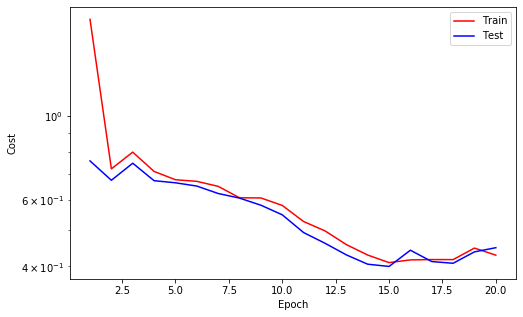

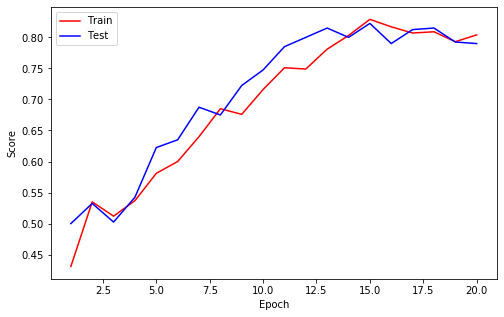

==> EarlyStop patience =  5 | Best test_score: 0.8225
==> Execute Early Stopping at epoch: 20 | Best test_score: 0.8225
==> Best model is saved at model


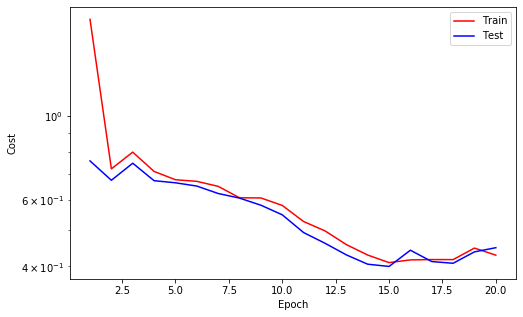

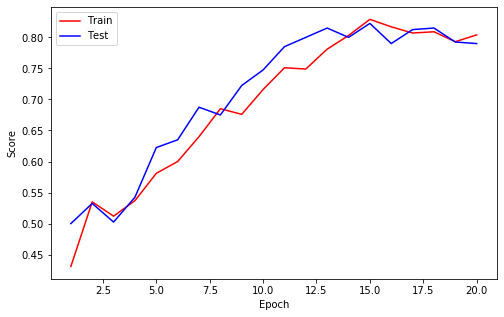

In [16]:
while True:
    train_cost, train_score = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging 
    callback.log(train_cost, test_cost, train_score, test_score)
    
    # Checkpoint
    callback.save_checkpoint()
    
    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

# Predict

In [17]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [18]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0])

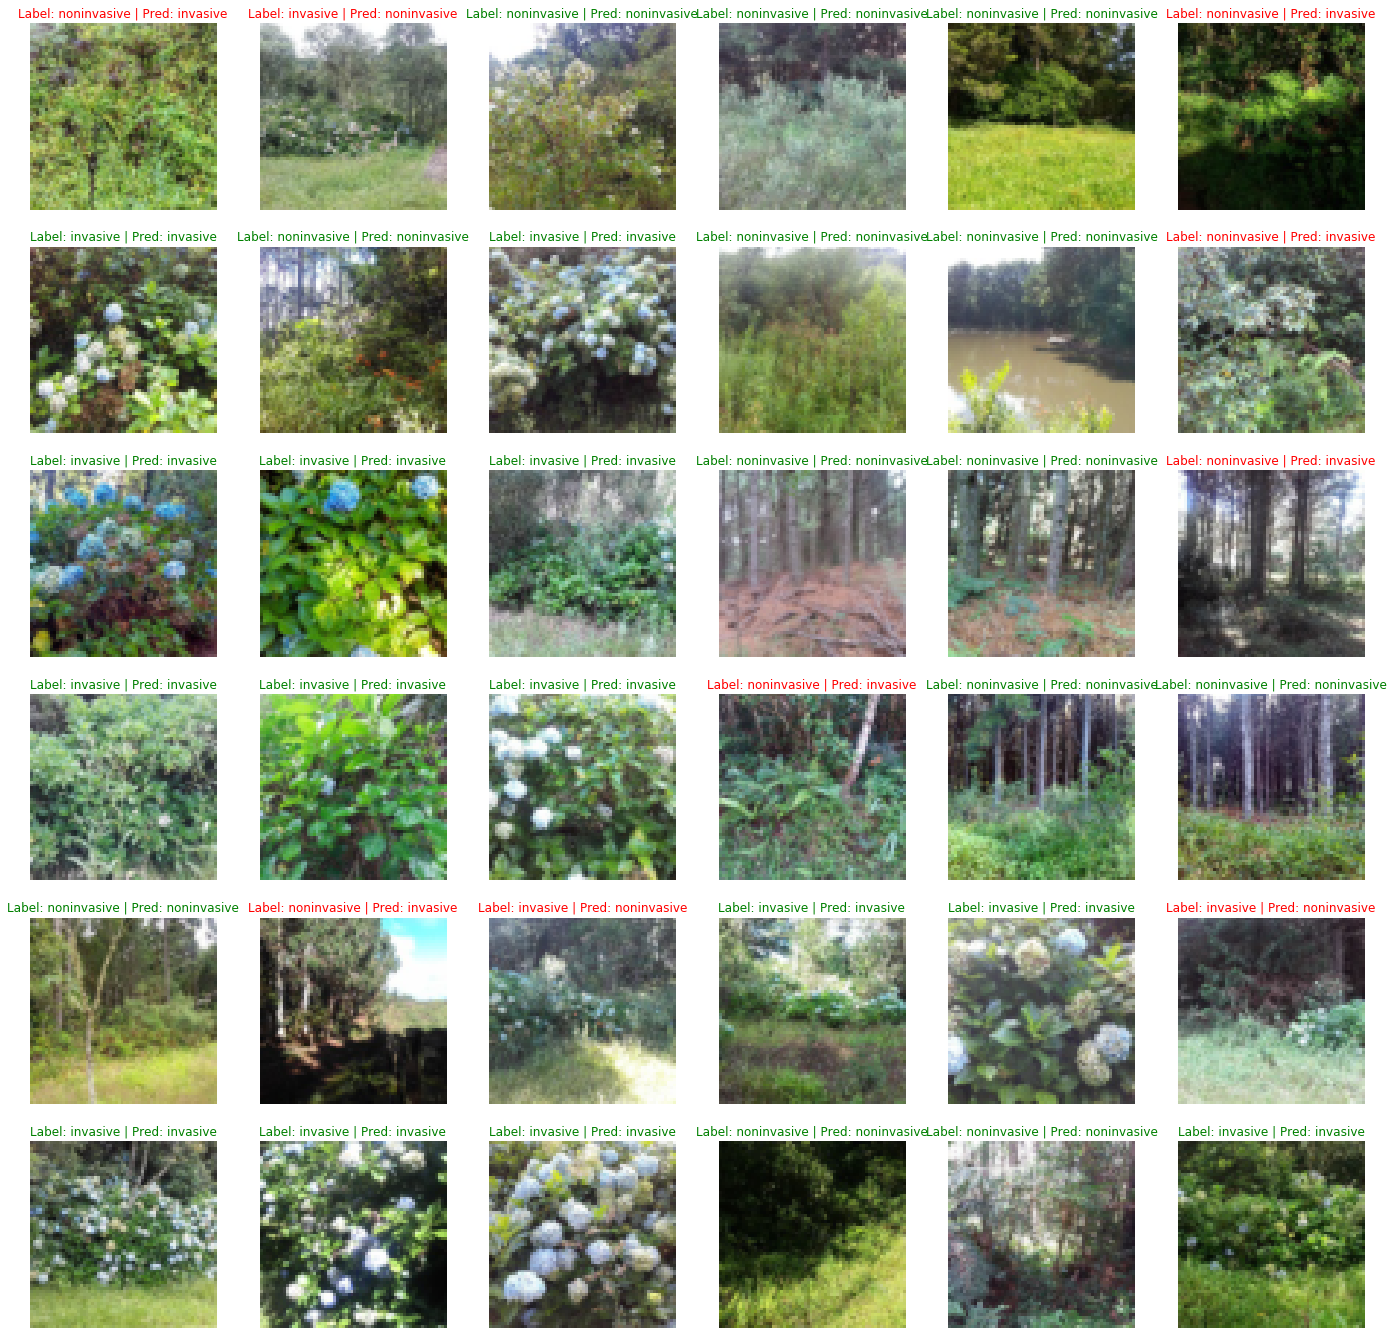

In [19]:
# plot prediction
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.permute(1, 2, 0).cpu())
    font = {"color":'r'} if label != pred else {"color":'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');